# Predicting Political Revolutions
Political upheavals have been ever present throughout humanity. Political leaders shape the context for everything we know. For that reason, we as a society need to generate a concrete understanding of when a revolution or political change is imminent. This analysis seeks to forecast whether a given protest will lead to a revolution within six months. 

The stakeholders for this analysis are wide reaching, but it is most relevant to political scientists, though could also provide insights for political organizers and leadership. The findings can be used to

They can use this approach to best understand where efforts are best focused and most likely to lead to an impact. 


---

## Notebook Structure
1. Data & Sources
2. Data Preparation
3. Modeling
4. Evaluation
5. Conclusion


---

## Part I. Data & Sources
The analysis combines three core datasets from widely different sources to provide a distinctly unique understanding of the subject. They are described below.

### The Mass Mobilization Project

The first dataset is described in the source documentation as "an effort to understand citizen movements against governments, what citizens want when they demonstrate against governments, and how governments respond to citizens. The MM data cover 162 countries between 1990 and 2018. These data contain events where 50 or more protesters publicly demonstrate against government, resulting in more than 10,000 protest events. Each event records location, protest size, protester demands, and government responses." [(1)](https://massmobilization.github.io/about.html) The project is sponsored by the Political Instability Task Force (PITF). The PITF is funded by the Central Intelligence Agency (CIA). [(1)](https://massmobilization.github.io/about.html) **Throughout this analysis, this dataset will be referred to as the "Protests" dataset.**

Although the data source does specify that the dataset is not entirely comprehensive of all country across this entire time period. That said, it does contain over 17,000 recorded protests, each composed of 31 features. The data span 167 countries from 1990 to 2020. 


#### Citation:

Clark, David; Regan, Patrick, 2016, "Mass Mobilization Protest Data", https://doi.org/10.7910/DVN/HTTWYL, Harvard Dataverse, V5, UNF:6:F/k8KUqKpCa5UssBbL/gzg== [fileUNF]



### The Polity Project
The second dataset codes "authority characteristics of states in the world system for purposes of comparative, quantitative analysis." [(2)](https://www.systemicpeace.org/polityproject.html) "The Polity5 dataset covers all major, independent states in the global system over the period 1800-2018 (i.e., states with a total population of 500,000 or more in the most recent year; currently 167 countries. The Polity conceptual scheme is unique in that it examines concomitant qualities of democratic and autocratic authority in governing institutions, rather than discreet and mutually exclusive forms of governance. This perspective envisions a spectrum of governing authority that spans from fully institutionalized autocracies through mixed, or incoherent, authority regimes (termed "anocracies") to fully institutionalized democracies." [(2)](https://www.systemicpeace.org/polityproject.html). Most relevant to this analysis, "it also records changes in the institutionalized qualities of governing authority."  [(2)](https://www.systemicpeace.org/polityproject.html). These changes in governing authority are the target feature of this analysis. It also contains 1,693 rows of data, each with 24 features. **Throughout this analysis, this dataset will be referred to as the "Regime Changes" or "Regimes" dataset.**


#### Citation: 

“The Polity Project.” PolityProject, Center for Systemic Peace, www.systemicpeace.org/polityproject.html. 



### The Database of Political Institutions

The third dataset is provided by the Inter-American Development Bank (IDB). "The Database of Political Institutions presents institutional and electoral results data such as measures of checks and balances, tenure and stability of the government, identification of party affiliation and ideology, and fragmentation of opposition and government parties in the legislature ... [it covers] about 180 countries [from] 1975-2020. It has become one of the most cited databases in comparative political economy and comparative political institutions, with more than 4,500 article citations on Google Scholar as of December 2020." [(3)](https://publications.iadb.org/en/database-political-institutions-2020-dpi2020) For the context of this analysis, it includes 8,200 rows of data, each with 77 features. **Throughout this analysis, this dataset will be referred to as the "Governments" dataset.** 


#### Citation:

Cruz, Cesi, Philip Keefer, and Carlos Scartascini. 2021. Database of Political Institutions 2020. Washington, DC: Inter-American Development Bank Research Department.

### Notes about the breakdown of the Jupyter notebooks used herein

Given the large-scale nature of the project, this notebook inevitably does not contain the entire analysis. It does not go into depth on each of the choices made for feature selection or data cleaning. Consider this the "top level" notebook, and those more detail-oriented parts of the analysis are handled in their own spaces. Here is where you should go to find more details:


1. **[cleaning_protests_dataset.ipynb](cleaning_protests_dataset.ipynb):** Refer to this notebook for a ground-up analysis of the "Protests" dataset. It includes important features such as the nature of each protest (size, objectives, location, etc.). Especially exhaustive and detailed data cleaning choices are made in this notebook.
2. **[cleaning_regime_changes_dataset.ipynb](cleaning_regime_changes_dataset.ipynb):** Refer to this notebook for a full study of the "Regime Change" data. Primarily, this data provides the target feature for the entire analysis: regime change. It indicates when and where political change occurs. Interesting feature engineering takes place here.
3. **[cleaning_governments_dataset.ipynb](cleaning_governments_dataset.ipynb):** Refer to this notebook for an impressively comprehensive dataset surrounding descriptive attributes of governments around the world over many decades. Important information includes the political system of countries at specified times, the tenure of the country's primary leader, and the percentage of the popular vote the leader received (where relevant). There are descriptors as granular as the total number of seats in congress (where relevant). Extensive feature selection takes place in this notebook.

----

## Part II. Data Preparation

This section provides a brief overview of some data preparation. Note that for the sake of readability and brevity, the majority of the actual data cleaning takes place in the above-mentioned notebooks. Please refer there for information on specific decisions made.

**Import packages used throughout analysis**

In [1]:
# Basic imporrts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sqlalchemy import create_engine
import pickle

# Model preprocessing and processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.base import clone

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Performance evaluation
from sklearn.metrics import f1_score, precision_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix, recall_score
import shap

# Display options
pd.options.display.max_columns = 200
%matplotlib inline

# Convenience for working with external .py files
%load_ext autoreload
%autoreload 2

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../src')
from custom_plots import *
from create_target import *
from remove_missing_data import *
from evaluate_model_performance import *

# Global constants
RANDOM_STATE = 2021

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Import "Regime Change" dataset**

Note that the SQL database being imported has been pre-cleaned with consequential feature engineering in the *cleaning_regime_changes_dataset.ipynb* notebook in this directory.

In [2]:
# Import cleaned database via SQL
engine = create_engine('sqlite:///../data/processed/regime_changes.db')
with engine.begin() as connection:
    df_regimes = pd.read_sql('SELECT * FROM regime_changes', con=connection)

# Type casting
df_regimes.startdate = pd.to_datetime(df_regimes.startdate)
df_regimes.enddate = pd.to_datetime(df_regimes.enddate)

**Import "Protests" dataset**

Similar to above, the SQL database has already cleaned with some feature engineering taking place. Refer to *cleaning_protests_dataset.ipynb* in this directory for specifics. 

In [3]:
# Import cleaned database via SQL
engine = create_engine('sqlite:///../data/processed/protests.db')
with engine.begin() as connection:
    df_protests = pd.read_sql('SELECT * FROM protests', con=connection)

# Type casting
df_protests.startdate = pd.to_datetime(df_protests.startdate)

**Import "Governments" dataset**

This SQL database has already undergone very notable, detail-oriented data cleaning in the *cleaning_governments_dataset.ipynb* notebook in this directory. Notably, it also serves the role of decreasing the number of features from 77 (in the original dataset) to 55 here. That number will again be substantially reduced in the data cleaning section below.

In [4]:
# Import cleaned database via SQL
engine = create_engine('sqlite:///../data/processed/governments.db')
with engine.begin() as connection:
    df_govts = pd.read_sql('SELECT * FROM governments', con=connection)

# Set index to be used in SQL join
df_govts.index = df_govts.year_scode

# Drop now-duplicated feature
df_govts.drop('year_scode', axis=1, inplace=True)

**Join "Protests" and "Governments" datasets**

By joining these two datasets, a new dataframe is created with each row corresponding to one protest, containing original features about that protest as well as the characteristics of the government in place in that country during the selected year. The two datasets are joined on the index of *"year_of_protest"_"three-letter_country_code"*, otherwise known as *"year_scode"*.

In [5]:
# Join both dataframes
df = df_protests.join(df_govts, how='left', on='year_scode')

# Remove entries that don't have corresponding 'government' data
df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15064 entries, 0 to 15207
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   country                            15064 non-null  object        
 1   scode                              15064 non-null  object        
 2   region                             15064 non-null  object        
 3   protestnumber                      15064 non-null  int64         
 4   protesterviolence                  15064 non-null  int64         
 5   startdate                          15064 non-null  datetime64[ns]
 6   duration_days                      15064 non-null  int64         
 7   participants                       15064 non-null  int64         
 8   participants_category              15064 non-null  object        
 9   demand_labor-wage-dispute          15064 non-null  int64         
 10  demand_land-farm-issue            

##### Identify countries that are missing from "Regime Changes" dataset

In [6]:
# All countries in union of Protests and Governments
all_countries = df.scode.unique()

# All countries in Regimes
regime_countries = df_regimes.scode.unique()


# Loop over all_countries
missing = []
for country in all_countries:
    # Make note of any countries not in Regimes
    
    if country not in regime_countries:
        missing.append(country)

print('Countries missing from "Regimes" dataset:', missing)

# Remove these countries from dataset
scodes_to_remove_ind = [x in missing for x in df.scode]
df.drop(df.loc[scodes_to_remove_ind].index, axis=0, inplace=True)

Countries missing from "Regimes" dataset: ['LUX']


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15061 entries, 0 to 15207
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   country                            15061 non-null  object        
 1   scode                              15061 non-null  object        
 2   region                             15061 non-null  object        
 3   protestnumber                      15061 non-null  int64         
 4   protesterviolence                  15061 non-null  int64         
 5   startdate                          15061 non-null  datetime64[ns]
 6   duration_days                      15061 non-null  int64         
 7   participants                       15061 non-null  int64         
 8   participants_category              15061 non-null  object        
 9   demand_labor-wage-dispute          15061 non-null  int64         
 10  demand_land-farm-issue            

**Join with "Regime Changes" dataset**

Add the third and final dataset, which includes the "target" feature of the analysis. 

In [8]:
target = create_target(df, df_regimes)
df = pd.concat([df, target], axis=1)
print(df.shape)
df.info()

(15207, 81)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15207 entries, 0 to 15207
Data columns (total 81 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   index                              15061 non-null  float64       
 1   country                            15061 non-null  object        
 2   scode                              15061 non-null  object        
 3   region                             15061 non-null  object        
 4   protestnumber                      15061 non-null  float64       
 5   protesterviolence                  15061 non-null  float64       
 6   startdate                          15061 non-null  datetime64[ns]
 7   duration_days                      15061 non-null  float64       
 8   participants                       15061 non-null  float64       
 9   participants_category              15061 non-null  object        
 10  demand_labor-wage-disp

### Basic cleaning

Start by running custom function that removes all features that don't have a minimum threshold of non-null values

In [9]:
# Remove entries with limited "government" data
df = remove_missing_data(df, 1000)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11840 entries, 0 to 15060
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   index                              11840 non-null  float64       
 1   country                            11840 non-null  object        
 2   scode                              11840 non-null  object        
 3   region                             11840 non-null  object        
 4   protestnumber                      11840 non-null  float64       
 5   protesterviolence                  11840 non-null  float64       
 6   startdate                          11840 non-null  datetime64[ns]
 7   duration_days                      11840 non-null  float64       
 8   participants                       11840 non-null  float64       
 9   participants_category              11840 non-null  object        
 10  demand_labor-wage-dispute         

In [10]:
# Convert startdate to a float instead of datetime since datetime cannot be 
# handled by models but fractional years can
df['startdate'] = df.startdate.dt.year + \
                  df.startdate.dt.month/12 + \
                  df.startdate.dt.day/365

In [11]:
# Type casting
df['region'] = df.region.astype('category')
df['system'] = df.system.astype('category')
df['country'] = df.country.astype('category')
df['xconst'] = df['xconst'].astype('int')

##### Fill "placeholder" values in *xconst* with continuous numbers. See Model.ipynb for further details.

In [12]:
df.xconst.replace(-66.0, -1, inplace=True) # 'Interruption periods'
df.xconst.replace(-77.0, -2, inplace=True) # 'Interregnum periods'
df.xconst.replace(-88.0, 0, inplace=True) # 'Transition periods'

#### Define target
This allows the user to define the target in terms of the amount of time before which a regime transition will occur. For this analysis, it uses 6 months, but other values have also been explored with similar results.

In [13]:
DAYS_UNTIL_CHG = 365/2 #6 months
target = pd.DataFrame(df['days_until_next_regime_chg'] < DAYS_UNTIL_CHG)
target = target.astype('int')
target.columns = ['target']

#### Drop unused columns

Refer to "model.ipynb" notebook for decision-making details. Specific descisions will not be discussed here as they are covered in depth in the previously mentioned file.

In [14]:
drop_cols = ['year_scode', 'scode_govt', 'country_govt', 'startdate',
             'days_until_next_regime_chg', 'scode', 'participants_category', 'participants',
             'next_regime_chg_date', 'index', 'duration_days', 'present', 'protestnumber']
df.drop(drop_cols, axis=1, inplace=True)


# Features with high collinearity
colinear_cols = ['liec', 'eiec', 'tenlong_strict', 'tenshort_strict', 'finittrm', 'govfrac', 'oppvote']
df.drop(colinear_cols, axis=1, inplace=True)

### Feature descriptions

Given the large number of features with abbreviated names, those that are used within the model are defined below.

Protest Details - as provided by *Protests* dataset:
- **country:** location of protest
- **region:** global region
- **protestnumber:** protest number in the selected country in a given year 
- **protesterviolence:** (y/n) indicator of protester violence
- **startdate:** first day of protest
- **participants:** number of individuals in attendance

---

Categorizations of the reason for a protest (multiple options possible) - as provided by *Protests* dataset:
-  **labor wage dispute** 
-  **land farm issue** 
-  **police brutality** 
-  **political behavior/process** 
-  **price increases/tax policy** 
-  **removal of politician** 
-  **social restrictions** 

---

Government descriptors in the given country at the time protest - as provided by *Government Characterization* dataset. Strict, quantifiable definitions are provided in Data Manual.

- **system:** governmental system (Parliamentary, Assembly-elected president, Presidential, Unelected)
- **yrsoffc:** number of years the chief executive has been in office
- **finittrm:** (y/n) is there a finite term in office?
- **military:** (y/n) is the chief executive a military officer?
- **totalseats:** total seats in the legislature
- **legelec:** (y/n) is there a legislative election in the protest year?
- **exelec:** (y/n) is there a executive election in the protest year?
- **liec:** legislative index of electoral competitiveness
- **eiec:** executive index of electoral competitiveness
- **gq:** are there gender quotas in government (None, Voluntary, Reserved, Required)
- **numvote:** total vote share of governmental leadership party
- **oppvote:** total vote share of all opposition parties
- **tensys_strict:** length of time the country has been autocratic or democratic
- **stabs_strict:** stability, as measured by the percent of veto players who *drop* from the government in a given year

---

Political regime authority characteristics - as provided by *Regime Changes* dataset. Strict, quantifiable definitions are provided in Data Manual.

- **parcomp:** competitiveness of political participation (Repressed, Suppressed, Factional, Transitional, Competitive)
- **parreg:** regulation of participation (Unregulated, Multiple Identity, Sectarian, Restricted, Regulated)
- **xconst:** executive constraints / decision rules (Unlimited Authority through Executive Parity)
- **xropen / xrcomp:** openness/competitiveness of executive recruitment (Closed, Designation, Election)
- **regime transition:** target feature for this analysis, quantified by a pre-specified level of change in above metrics. See data dictionary for in-depth technical definition of political regime transition. Note that the purpose of this analysis is not to define what a regime transition is, but rather to use existing definitions to best understand the circumstances under which they do occur.

In [15]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11840 entries, 0 to 15060
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   country                            11840 non-null  category
 1   region                             11840 non-null  category
 2   protesterviolence                  11840 non-null  float64 
 3   demand_labor-wage-dispute          11840 non-null  float64 
 4   demand_land-farm-issue             11840 non-null  float64 
 5   demand_police-brutality            11840 non-null  float64 
 6   demand_political-behavior/process  11840 non-null  float64 
 7   demand_price-increases/tax-policy  11840 non-null  float64 
 8   demand_removal-of-politician       11840 non-null  float64 
 9   demand_social-restrictions         11840 non-null  float64 
 10  participants_log                   11840 non-null  float64 
 11  duration_days_log                  11840 

None

,protesterviolence,demand_labor-wage-dispute,demand_land-farm-issue,demand_police-brutality,demand_political-behavior/process,demand_price-increases/tax-policy,demand_removal-of-politician,demand_social-restrictions,participants_log,duration_days_log,protestnumber_log,yrsoffc,termlimit,military,defmin,execnat,totalseats,oppmajh,legelec,exelec,gq,gqi,auton,numvote,maj,herfgov,tensys_strict,checks,stabs_strict,xconst
count,11840.000000,11840.00000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.00000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000,11840.000000
mean,0.270861,0.14848,0.042821,0.072973,0.695861,0.095777,0.119848,0.04603,6.393136,0.213862,1.537112,5.750929,2.277196,0.111149,0.179730,0.094679,377.896453,0.011993,0.224578,0.142314,1.080659,0.292230,0.233024,0.328129,0.617021,2.207455,30.077956,3.433277,0.124362,5.185051
std,0.444423,0.35559,0.202462,0.260103,0.460061,0.294298,0.324797,0.20956,2.319513,0.678007,1.111790,6.325907,1.517871,0.314329,0.383978,0.292783,469.740206,0.108860,0.417322,0.349387,1.133387,0.455178,0.422775,0.278934,0.188798,32.098967,24.883886,1.820923,0.265677,2.103327
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.912023,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031579,0.089841,1.000000,1.000000,0.000000,-2.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,4.605170,0.000000,0.693147,2.000000,1.000000,0.000000,0.000000,0.000000,139.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.505882,0.559558,10.000000,2.000000,0.000000,3.000000
50%,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,6.214608,0.000000,1.386294,4.000000,1.000000,0.000000,0.000000,0.000000,290.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.404000,0.584000,0.965207,22.000000,3.000000,0.000000,6.000000
75%,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,8.006368,0.000000,2.302585,7.000000,3.000000,0.000000,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.520000,0.747685,1.000000,43.000000,4.000000,0.000000,7.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,15.761421,6.595781,4.962845,46.000000,8.000000,1.000000,1.000000,1.000000,3000.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,729.728271,90.000000,18.000000,1.000000,7.000000


---

## Part III. Modeling

Given the cleaned and aggregated dataset above, the next section moves into the Modeling phase. It uses the following general structure:

1. Test, train, and validation splits
2. "Dummy" model for baseline performance metric
3. Logistic regression model
4. Random forest model
5. XG boost model

Note that in the *MODEL.ipynb* notebook, alternative models are explored, such as K-Nearest Neighbors (KNN), Bayesian classifiers, ADA boost, and Decision Trees. 

Each model type is constructed using elements of encoding, scaling, resampling and hyperparameter optimization.

- One hot encoding was essential given the categorical type of some features
- Standard scaling was essential given the vast array of different numerical feature distributions and ranges. Min-max scaling was considered but proved less effective.
- SMOTE was determined to be essential given the imbalanced nature of the dataset. Only 11% of the target feature values were 1, leaving the other 89% as 0. This is a prime example of the need for resampling, and SMOTE proved highly effective.
- Hyperparameter grid searches are inherently valuable when optimizing a model. Appropriate hyperparameter searches were used for each model type.

The output of each model is provided in terms of four core statistical measures (f1 score, accuracy, precision, and recall), in addition to displaying a confusion matrix for the test data. F1 was selected before the modeling process as the most relevant metric given that it encomasses all possible outcomes, as opposed to the other three metrics which leave out at least one possible outcome from their evaluation. 

Lastly, the grid search is not actually completed in this file. The code shows the way in which the pipelines were established as well as the data to be used. However, in order to save the time of a thorough grid search twice, the calculations are completed in the MODEL file and exported via a Pickle file. They are then imported here after the grid search is complete. 

**Create train-test split**

In [16]:
# Create standard train-test splits
x_train, x_test, y_train, y_test = train_test_split(df, target, 
                                                    random_state=RANDOM_STATE, 
                                                    test_size=0.3)

**Create baseline "dummy" model**

In [17]:
# Create instance of dummy classifier and fit to training data
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(x_train, y_train)

# Create model predictions for test data
pred_dummy = dummy_clf.predict(x_test)
print_scores(pred_dummy, y_test)

- f1: 0.04888888888888889
- accuracy: 0.8795045045045045
- precision: 0.049107142857142856
- recall: 0.048672566371681415


**Create Logistic Regression classifier model**

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


- f1: 0.31860036832412525
- accuracy: 0.7916666666666666
- precision: 0.20116279069767443
- recall: 0.7654867256637168


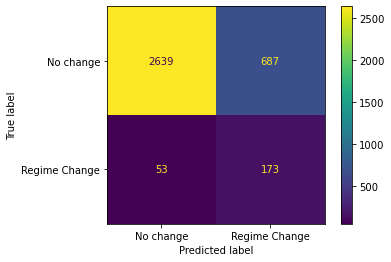

In [18]:
# Instantiate model
model_log = LogisticRegression(max_iter=5000)

# Add one-hot encoding for categoricals
ohe = OneHotEncoder(handle_unknown='ignore')

# Add standard scaling
scaler = StandardScaler()

# Add resampling to address class imbalance
smote = SMOTE(random_state=RANDOM_STATE)


# Select object types for one-hot encoding and numeric types for scaling
selector_object = make_column_selector(dtype_exclude='number')
selector_numeric = make_column_selector(dtype_include='number')

# Create transformer for the selectors/encoders/scalers
transformer = make_column_transformer((ohe, selector_object),
                                     (scaler, selector_numeric))


# Create pipeline for transformer, resampling, and model
pipe = Pipeline([('transformer', transformer),
                 ('smote', smote), 
                 ('model', model_log)])

# Run grid search to optimizer hyperparameters
grid_log = {'model__C': np.logspace(-1, 5, 20)}
grid_search = GridSearchCV(pipe, grid_log, scoring='f1', cv=10)

# Fit model to training data
# grid_search.fit(x_train, y_train)

# As described in this section's header, the fitted pipeline is 
# simply imported via Pickle from the MODEL notebook, where it was
# fitted on the same data.
with open('../data/processed/model_logreg.pickle', 'rb') as f:
    model_logreg = pickle.load(f)

    
# Fit pipeline
model_logreg.fit(x_train, y_train)

# Print metrics
prediction = model_logreg.predict(x_test)
print_scores(prediction, y_test)

# Display confusion matrix
labels = ['No change', 'Regime Change']
plot_confusion_matrix(model_logreg, x_test, y_test, display_labels=labels);

Overall, the Logistic Regression model performance is underwhelming, albeit substantially better than the baseline model: an F1 score performance of ___ instead of the baseline _ . Still, it seems that the model does not capture the complexity of the data. Below more complex models are explored.


**Create Random Forest model**

Reuse one-hot encoder, scaler, resampler, selectors, transformer from logistic regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


- f1: 0.6214953271028038
- accuracy: 0.9543918918918919
- precision: 0.6584158415841584
- recall: 0.588495575221239


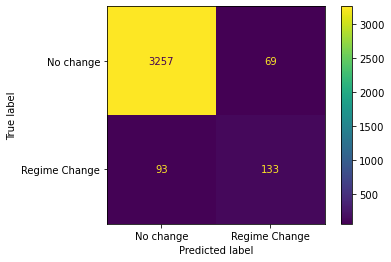

In [19]:
# Instantiate model
model_rf = RandomForestClassifier()

# Create pipeline for transformer, resampling, and model
pipe = Pipeline([('transformer', transformer),
                 ('smote', smote), 
                 ('model', model_rf)])

# Run grid search to optimizer hyperparameters
grid_rf = {
    'model__n_estimators': [25, 75, 150],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 6, 10],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}

# Create instance of grid search
grid_search = GridSearchCV(pipe, grid_rf, scoring='f1', cv=5)

# Fit model to training data
# grid_search.fit(x_train, y_train)

# As described in this section's header, the fitted pipeline is 
# simply imported via Pickle from the MODEL notebook, where it was
# fitted on the same data.
with open('../data/processed/model_rf.pickle', 'rb') as f:
    model_rf = pickle.load(f)

# Fit pipeline
model_rf.fit(x_train, y_train)
    
# Print metrics
prediction = model_rf.predict(x_test)
print_scores(prediction, y_test)

# Display confusion matrix
plot_confusion_matrix(model_rf, x_test, y_test, display_labels=labels);

The random forest model shows substantial performance over the logistic regression model. Specifically, the F1 score increase by XXX, and other metrics see similar improvements. Still, the performance isn't perfect, so the below model explores an increasingly complex model that is able to better capture the complexity of the data.

**XG Boost model**

- f1: 0.7529976019184652
- accuracy: 0.9710022522522522
- precision: 0.8219895287958116
- recall: 0.6946902654867256


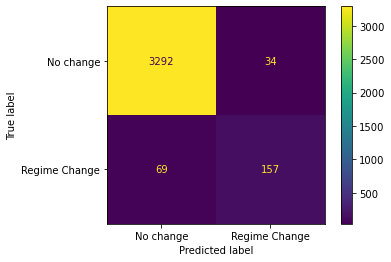

In [20]:
# Instantiate model
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, 
                          random_state=RANDOM_STATE)

# Create pipeline for transformer, resampling, and model
pipe = Pipeline([('transformer', transformer),
                 ('smote', smote), 
                 ('model', model_xgb)])


# Run grid search to optimizer hyperparameters
grid_xgb = {
    'model__learning_rate': [0.01, 0.1, 0.25],
    'model__max_depth': [6, 8, 10, 12],
    'model__subsample': [0.4, 0.7, 1],
    'model__n_estimators': [100, 200, 300, 400]}

# Fit model to training data
# grid_search.fit(x_train, y_train)

# As described in this section's header, the fitted pipeline is 
# simply imported via Pickle from the MODEL notebook, where it was
# fitted on the same data.
with open('../data/processed/model_xgb.pickle', 'rb') as f:
    model_xgb = pickle.load(f)

# Fit pipeline
model_xgb.fit(x_train, y_train)
    
# Print metrics
prediction = model_xgb.predict(x_test)
print_scores(prediction, y_test)

# Display confusion matrix
plot_confusion_matrix(model_xgb, x_test, y_test, display_labels=labels);

**Show optimal model hyperparameters**

In [21]:
print(model_xgb.steps[2])

('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, random_state=2021, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None))


**The model performance does increase using the XG Boost model relative to all other previously tested models**

All performance metrics improve significantly over the Random Forest model.

---

## Part IV. Evaluation

As can be seen based on the F1 scores – the metric chosen at the beginning of the analysis as most relevant – the XG boost model performs the best. This section will test the final model on the test data as well as visualize feature significance to the extent feasible. 

**Evaluate performance on test data**

The below metrics show strong model performance on the test data with nearly no noteworthy indication of overfitting

- f1: 0.7529976019184652
- accuracy: 0.9710022522522522
- precision: 0.8219895287958116
- recall: 0.6946902654867256


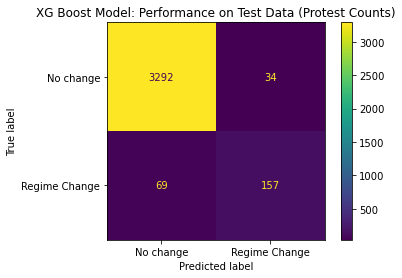

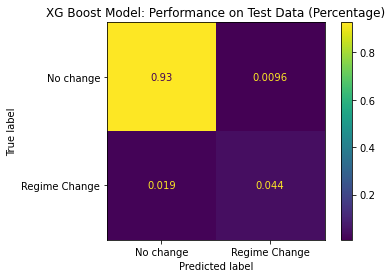

In [22]:
# Calculate predicted output of test data
prediction = model_xgb.predict(x_test)

# Print performance metrics
print_scores(prediction, y_test)

# Display confusion matrix (not normalized)
plot_confusion_matrix(model_xgb, x_test, y_test, display_labels=labels)
plt.title('XG Boost Model: Performance on Test Data (Protest Counts)')
plt.show()

# Display confusion matrix (normalized)
plot_confusion_matrix(model_xgb, x_test, y_test, normalize='all', display_labels=labels)
plt.title('XG Boost Model: Performance on Test Data (Percentage)');

**To identify overfitting, test the final model on the full dataset (train *and* test)**

Although these metrics aren't used to state overall performance, they can be interesting and can help identify overfitting if the performance on *all* data is substantially higher than the performance on *test* data. The below printouts show that overfitting is significant, though the performance on the test data remains sufficiently strong for a high performing model.

- f1: 0.9311036789297659
- accuracy: 0.9913006756756757
- precision: 0.9534246575342465
- recall: 0.9098039215686274


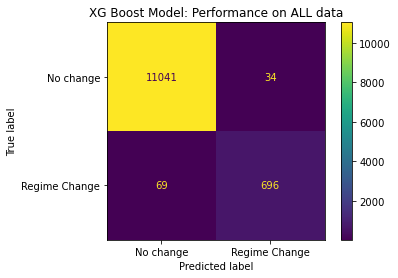

In [23]:
# Calculate predicted output of *all* data
prediction = model_xgb.predict(df)

# Print performance metrics
print_scores(prediction, target)

# Display confusion matrix
plot_confusion_matrix(model_xgb, df, target, display_labels=labels)
plt.title('XG Boost Model: Performance on ALL data');

**Investigate feature importance**

1. 
2. 
3. 
4. 

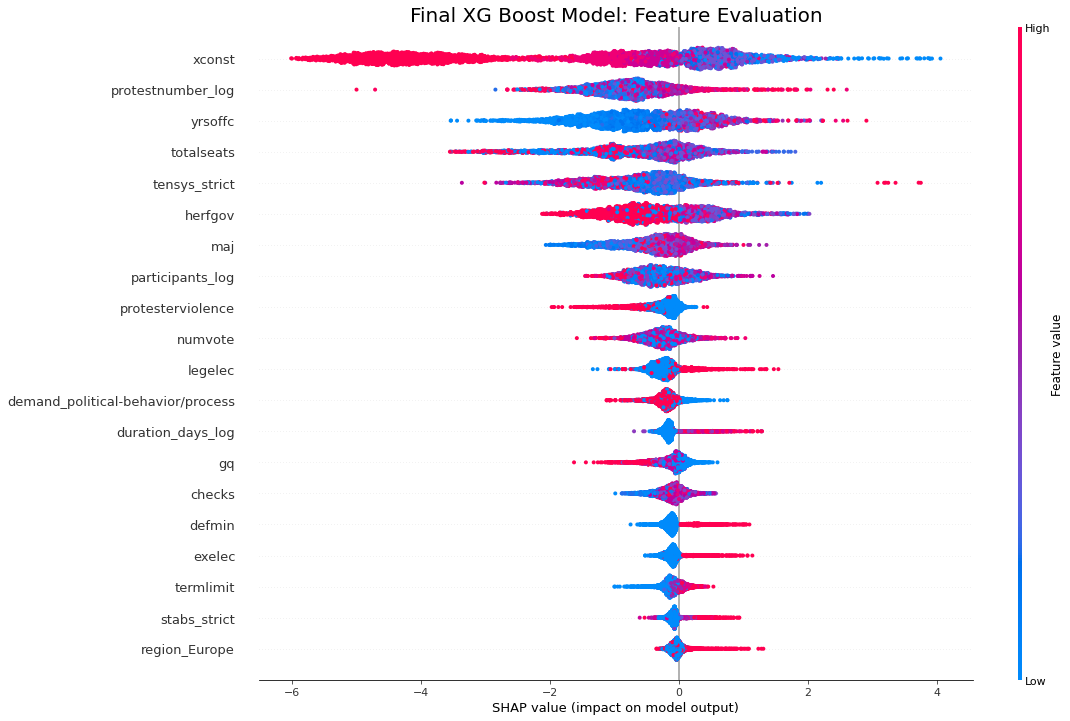

In [24]:
# SHAP summary plot for XGB
produce_shap_plot(x_train, y_train, x_test, y_test, clone(model_xgb), 
                  title='Final XG Boost Model: Feature Evaluation');

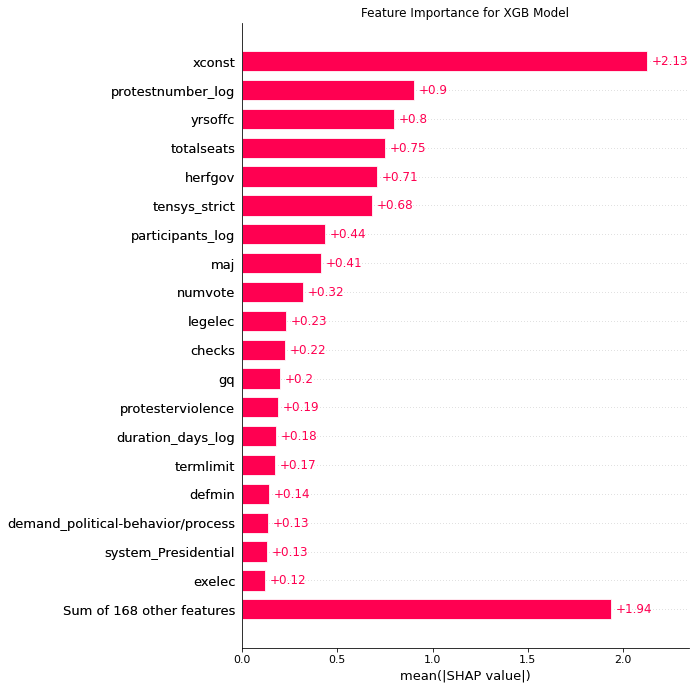

In [31]:
# SHAP bar plot for XGB model
x_tr_manual, y_tr_manual, x_te_manual = get_shap_df(x_train, y_train, x_test)
model = model_xgb.steps[2][1]

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(x_te_manual)

# SHAP bar plot for XGB model
plt.title('Feature Importance for XGB Model')
shap.plots.bar(shap_values, max_display=20)

## Part V. Conclusion

Overall, this analysis successfully completes its objective. It creates and tunes a model that helps predict whether a given protest will lead to a regime transition within one year. This incredibly valuable tool can be used by stakeholders far and wide as an indicator of disruption to come, which in turn can be used for proactive or preventative measures by either side. With a very strong performing model, it can be trusted to give an accurate estimate of changes to come. 

Going forward, this project allows for easy growth as more data is released. Each of the three primary datasets receive regular updates, and this new information can easily be incorporated in order to expand the temporal scope of the project and with more data comes to potential for stronger performance. 
